In [70]:
import numpy as np
import jax.numpy as jnp
from jax import random
import jax.nn as nn
import jax
import matplotlib.pyplot as plt
from jax.tree_util import tree_map
import optax

In [71]:
seed = 0
batch_size = 512
intermediate_embeding_time_dimension = 128
intermediate_features_embedding = 128
# epsilon = 0.01 # smallest time considered
num_timesteps = 400
num_training_steps = 20_000


# Dataloader and Diffusion : test equivalence between instant and step by step

In [72]:
def generateBatchPoints(key, distribution = 'spiral', batch_size=batch_size) :
    if distribution == 'spiral' :
        key1, key2 = random.split(key)
        radius = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)**.5
        noise = 0.01*random.normal(key2, shape = (batch_size,2))
        angle = 10*radius # angle from the first axis
        positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise
    # if distribution == 'two gaussians':
    #     key1, key2 = random.split(key)
    #     gauss_continuous_index = random.uniform(key1, shape = (batch_size,1) , minval= 0., maxval= 1.)
    #     z = random.normal(key2, shape = (batch_size,2))

    #     positions = jnp.concatenate( (radius*jnp.cos(angle),radius*jnp.sin(angle)), axis=1  ) + noise

    return(positions[...,None])


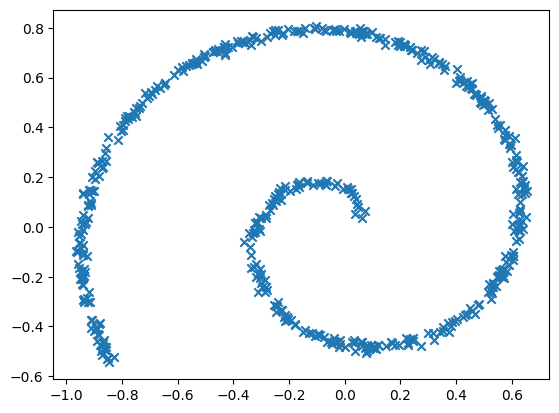

In [73]:
# Test
key = random.PRNGKey(seed)
samples = generateBatchPoints(key)

plt.scatter( samples[:,0,0],samples[:,1,0], marker = 'x')
plt.show()

In [74]:
def diffuseBatch(key, positions, sigma) :
    batch_size = positions.shape[0]
    noise = random.normal(key, shape = (batch_size,2,1))
    return(positions + sigma*noise)


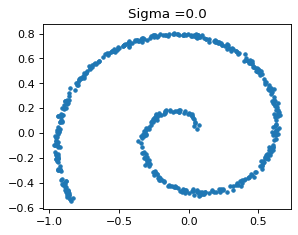

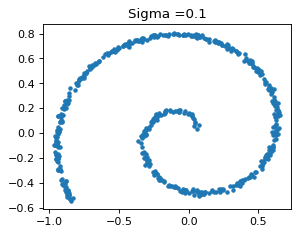

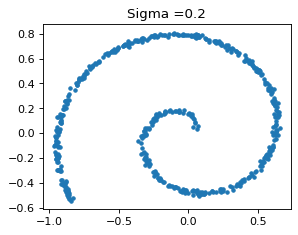

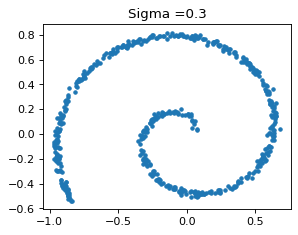

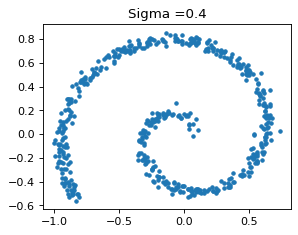

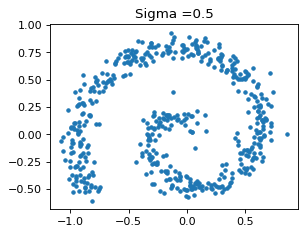

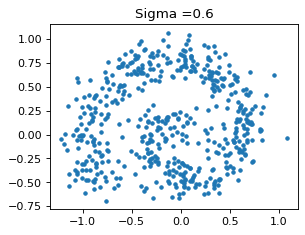

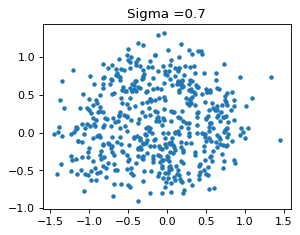

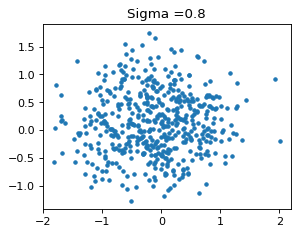

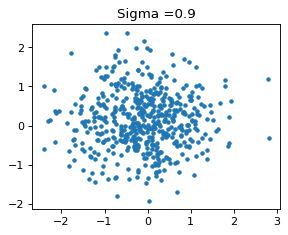

In [75]:
# Test
key = random.PRNGKey(seed)
key2, key3 = random.split(key)
samples = generateBatchPoints(key)

for sigmax10 in range(10) :
    sigma = (sigmax10/10.)**4*np.ones((batch_size,1,1))
    samples_noisy = diffuseBatch(key2, samples, sigma)
    plt.figure(figsize=(4, 3), dpi=80)
    plt.scatter( samples_noisy[:,0,0], samples_noisy[:,1,0], marker = '.')
    plt.title("Sigma =" + str(sigmax10/10.))
    plt.show()

# MLP layer and model

In [76]:
def initialiseMLPParams(key, shapes) :
    """
    Only valid for 1d MLP
    """
    params = []
    for i, (shape1, shape2) in enumerate( zip(shapes[:-1], shapes[1:]) ) :
        key, subkey = random.split(key)
        weights = random.normal(key, shape= (shape2,shape1) )/jnp.sqrt(shape1) # /jnp.sqrt(shape1) allows to have same order of magnitude to output as input
        biases = random.normal(subkey, shape= (shape2,1) )/jnp.sqrt(shape1)
        params.append({ "weights":weights, "biases":biases })
    key = random.split(key, num=1)[0]
    return(key,params)
    

In [77]:
#test 
shapes = (2,128,134,2)
key, params = initialiseMLPParams(key, shapes)
tree_map(lambda x: print("la",x.shape)  , params ) 

la (128, 1)
la (128, 2)
la (134, 1)
la (134, 128)
la (2, 1)
la (2, 134)


[{'biases': None, 'weights': None},
 {'biases': None, 'weights': None},
 {'biases': None, 'weights': None}]

In [78]:

def batchMLPNetwork(params, batch) :
    """
    input :
    - params : should be a list of dictionaries with keys 'weights' and 'biases'
    - batch : array of size (batch_size , 2, 1)
    """
    activation = batch
    for layer in params[:-1] :
        
        weights = layer['weights']
        biases = layer['biases']
        activation = nn.relu(jnp.matmul(weights,activation) + biases)
    
    last_layer = params[-1]
    weights = last_layer['weights']
    biases = last_layer['biases']
    logit = jnp.matmul(weights,activation) + biases
    return(logit) 

In [79]:
# test
batch = jnp.ones(shape= (batch_size,2,1))
batchMLPNetwork(params, batch)

Array([[[0.13968433],
        [0.45672357]],

       [[0.13968433],
        [0.45672357]],

       [[0.13968433],
        [0.45672357]],

       ...,

       [[0.13968433],
        [0.45672357]],

       [[0.13968433],
        [0.45672357]],

       [[0.13968433],
        [0.45672357]]], dtype=float32)

# learning diffusion step by step

In [80]:
@jax.jit
def PositionalEncoding(time_indices, embed_dimension = intermediate_embeding_time_dimension) :
    """ 
    - time_indices : shape (batch_size,) , should be int between 0 and num_timesteps
    - embed_dimension : dimension of the embeded time, *must be even* for definition of k in the function !
    """ 
     
    magic_number = 1000 # custom magic number addapted for embed_dimension = 128 
    times = time_indices.reshape( (1,-1) )
    k = jnp.arange( 0, embed_dimension//2 ).reshape((-1,1))

    ### might not be the most elegant way to do this ? :

    embedding = jnp.array([ jnp.cos( times/(magic_number**(2.*k/embed_dimension)) ) , jnp.sin( times/(magic_number**(2.*k/embed_dimension)) ) ])
    # embedding shape is (2, embed_dimension/2, batch_size) and should become (batch_size, embed_dim)
    embedding = jnp.transpose(embedding, (2,1,0))
    embedding = embedding.reshape((-1, embed_dimension ))

    ###

    return(embedding)


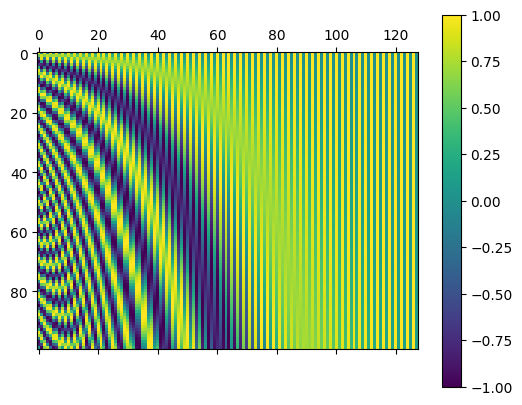

In [81]:
# test 
embedded = PositionalEncoding(jnp.arange(0,100))

plt.matshow(embedded)
plt.colorbar()
plt.show()

In [82]:
@jax.jit
def score(parameters,batch,time_indices) :
    """
    input :
    - parameters : a dictionary with three keys 'params_times', 'params_positions', 'params_global' for the respectives MLP
    - batch : positions batch shape (batch_size, 2, 1)
    - time_indices : shape (batch_size,) should be integers (float of int)
    output :
    - shape (batch_size,2,1)
    """
    time_embedding = PositionalEncoding(time_indices)
    params_times, params_positions, params_global = parameters['params_times'], parameters['params_positions'], parameters['params_global']

    time_embedding = batchMLPNetwork(params_times, time_embedding[...,None])
    position_embedding = batchMLPNetwork(params_positions, batch)

    global_embedding = jnp.concatenate( (time_embedding, position_embedding) , axis = 1)

    result = batchMLPNetwork(params_global, global_embedding)
    return(result)
    

In [83]:
def generateParameters(key):
    shapes_times = ( intermediate_embeding_time_dimension, 128,128, intermediate_features_embedding)
    shapes_positions = ( 2, 128,128 ,intermediate_features_embedding)
    shapes_global = (2*intermediate_features_embedding, 256, 256, 2)

    key, params_times = initialiseMLPParams(key, shapes_times)
    key, params_positions = initialiseMLPParams(key, shapes_positions)
    key, params_global = initialiseMLPParams(key, shapes_global)

    parameters = { 'params_times' : params_times,
                'params_positions' : params_positions,
                'params_global' : params_global }
    
    return(key,parameters)

In [84]:
# test 
key, parameters = generateParameters(key)

times = jnp.ones((batch_size,))
batch = random.normal(key, (batch_size,2,1) )
result = score(parameters, batch, times )
print(result.shape)

(512, 2, 1)


In [85]:
def timeIndices2sigma(time_indices) :
    """ 
    - time_indices : shape (batch_size,) integers 
    """ 
    # we choose a simple sigma for now
    return( 5*(time_indices*1./num_timesteps)**4) # **4 because **2 for def of sigma and **2 for modulation of timesteps 

In [86]:
@jax.jit
def batch_loss(parameters, key) :
    key, key2, key3, key4 = random.split(key,4)

    # sampling times
    time_indices = random.randint(key2, shape = (batch_size,), minval= 0, maxval= num_timesteps)
    sigmas = timeIndices2sigma(time_indices)

    # sampling initial data 
    batch = generateBatchPoints(key3, distribution = 'spiral', batch_size=batch_size)
    noisy_batch = diffuseBatch(key4, batch, sigmas[:,None,None])
    loss = jnp.sum( ( sigmas[:,None,None]*score(parameters,noisy_batch,time_indices) + (noisy_batch - batch)/2. )**2 )

    return(loss)
    

In [87]:
# test 
batch_loss(parameters, key)

Array(2835.0405, dtype=float32)

In [88]:
key, parameters = generateParameters(key)

learning_rate = 0.005
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(parameters)

loss_cache = []
for i in range(num_training_steps) :
    key = random.split(key, 1)[0]

    if i%500 == 0 :
        value, grads = jax.value_and_grad(batch_loss)(parameters, key)
        loss_cache.append(value)
        print( "step :", str(i), "   -   loss :", str(np.mean(loss_cache)))
        loss_cache = [] 
    else :
        value, grads = jax.value_and_grad(batch_loss)(parameters, key)
        loss_cache.append(value)
    
    updates, opt_state = optimizer.update(grads, opt_state)
    parameters = optax.apply_updates(parameters, updates)
    


step : 0    -   loss : 1815.7778
step : 500    -   loss : 41.670086
step : 1000    -   loss : 28.48301
step : 1500    -   loss : 27.756256
step : 2000    -   loss : 27.354645
step : 2500    -   loss : 27.365442
step : 3000    -   loss : 27.044497
step : 3500    -   loss : 27.35777
step : 4000    -   loss : 27.003082
step : 4500    -   loss : 27.022652
step : 5000    -   loss : 26.80526
step : 5500    -   loss : 26.902555
step : 6000    -   loss : 26.935585
step : 6500    -   loss : 26.64466
step : 7000    -   loss : 26.910276
step : 7500    -   loss : 26.5421
step : 8000    -   loss : 26.544554
step : 8500    -   loss : 26.525343
step : 9000    -   loss : 26.198391
step : 9500    -   loss : 26.291624
step : 10000    -   loss : 26.3193
step : 10500    -   loss : 26.186178
step : 11000    -   loss : 26.119043
step : 11500    -   loss : 26.186003
step : 12000    -   loss : 25.981756
step : 12500    -   loss : 26.047874
step : 13000    -   loss : 25.998446
step : 13500    -   loss : 26.006

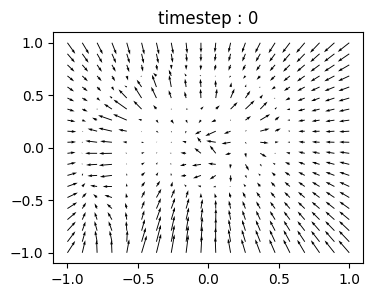

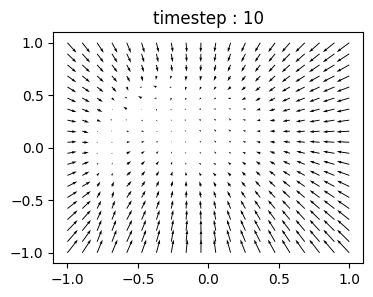

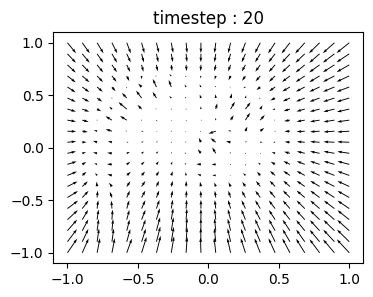

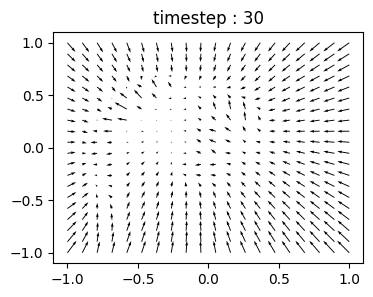

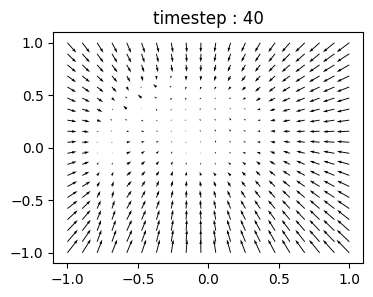

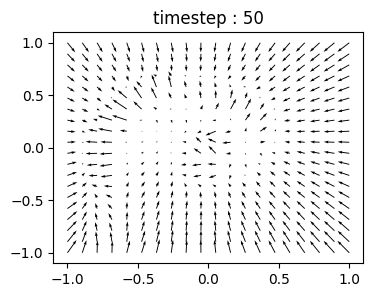

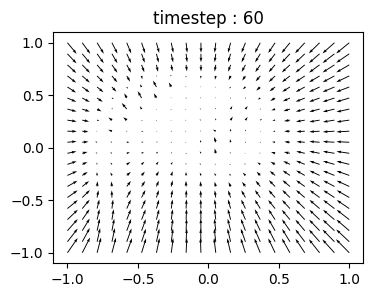

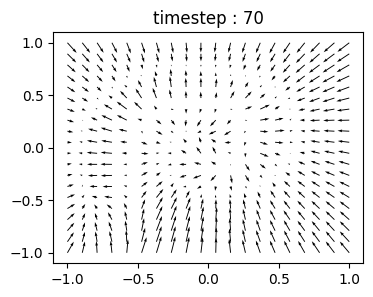

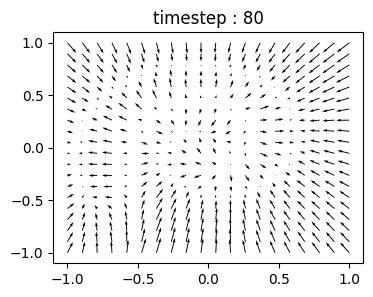

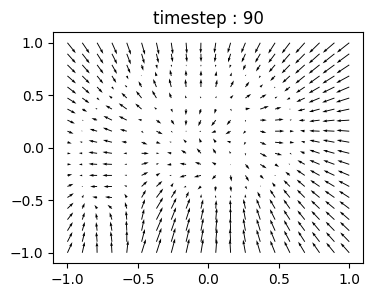

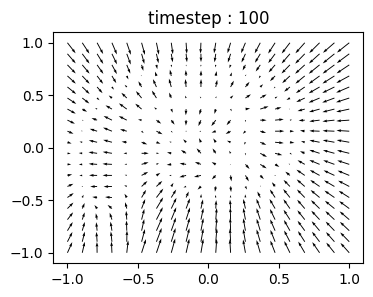

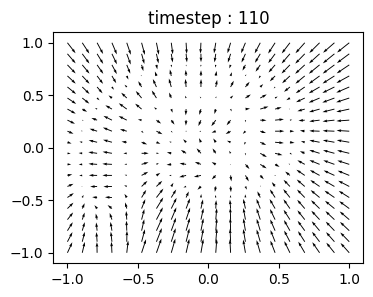

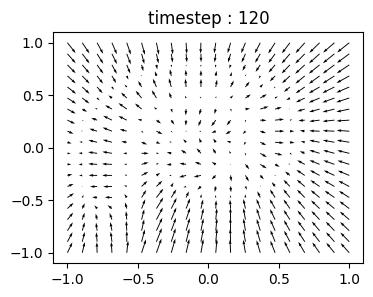

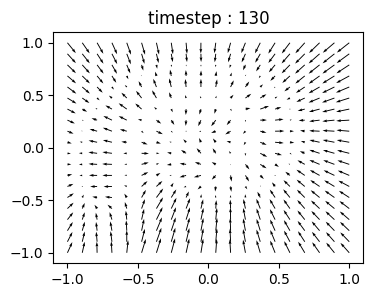

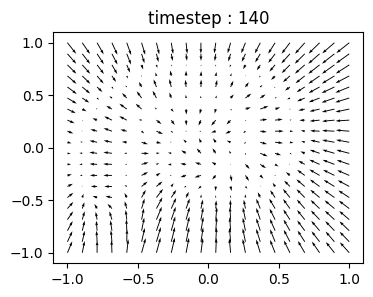

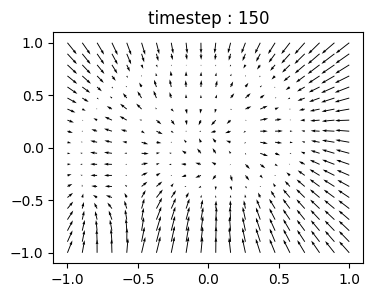

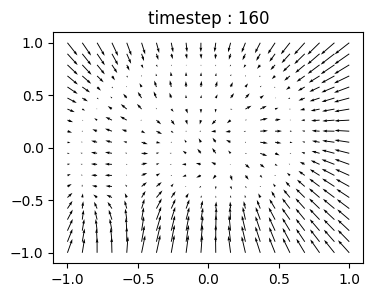

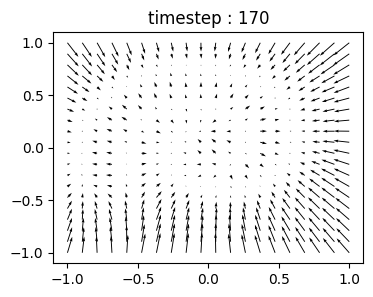

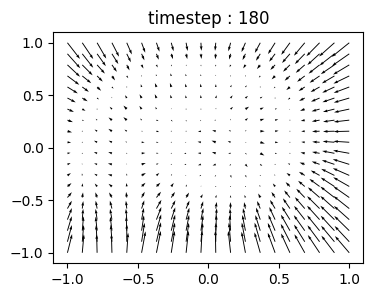

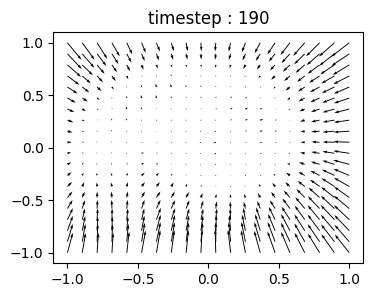

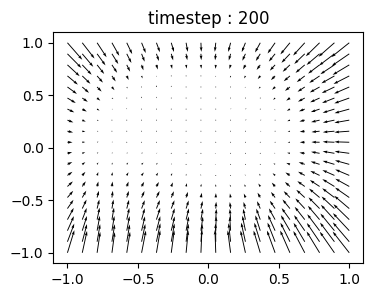

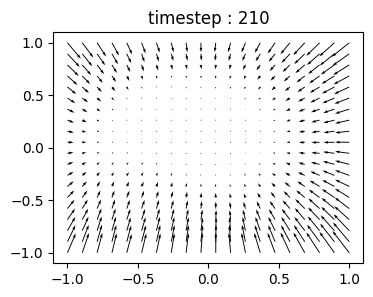

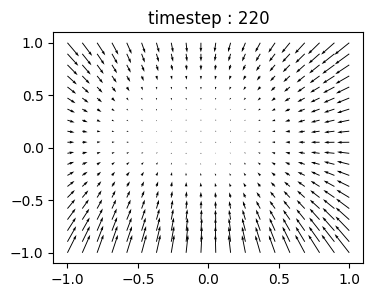

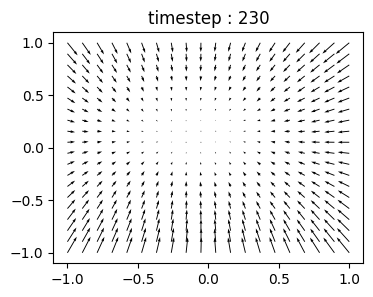

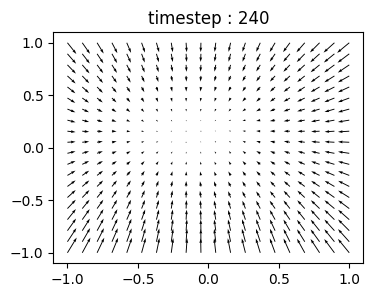

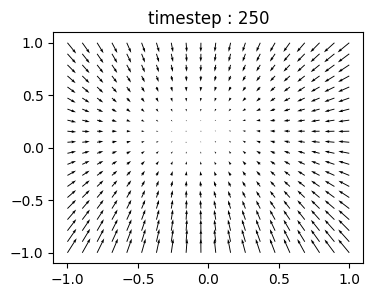

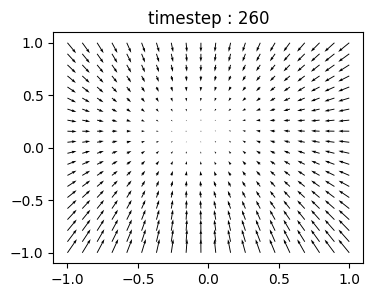

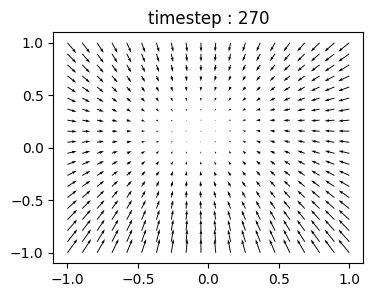

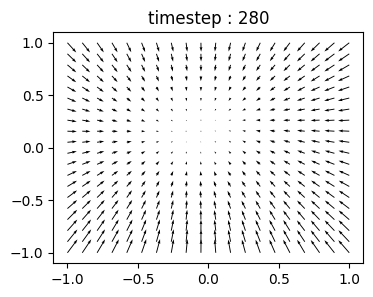

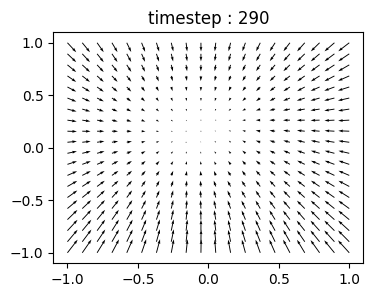

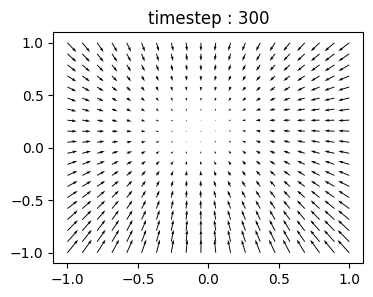

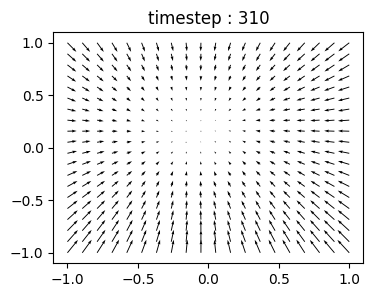

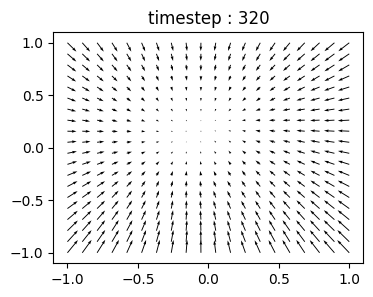

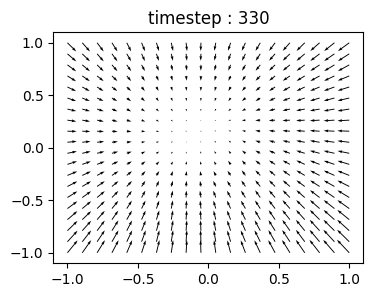

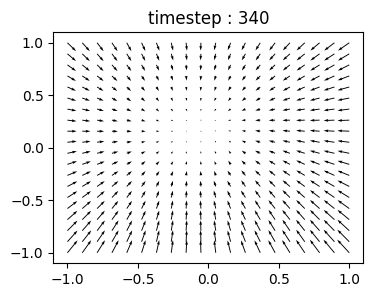

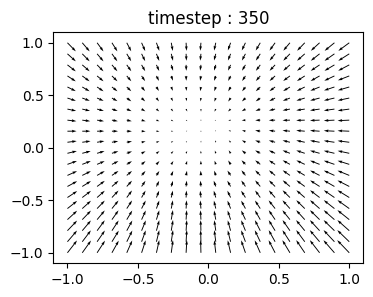

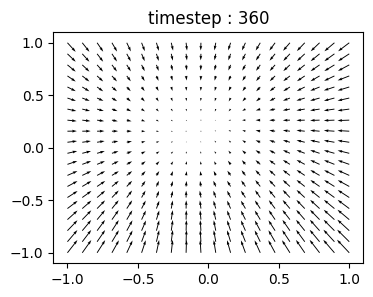

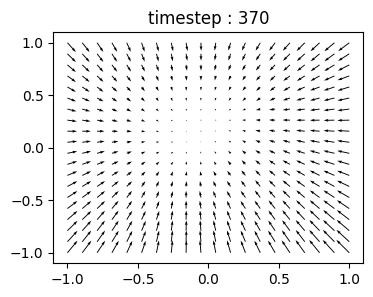

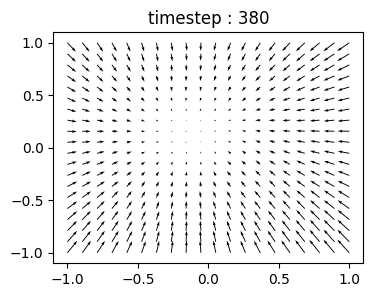

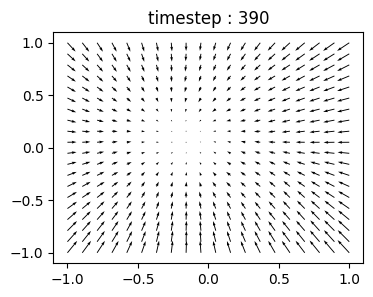

In [115]:
# test 
# Batch_size must be superior to 400 for this test
for timestep in range(0,num_timesteps,10) :
    x,y = np.meshgrid(np.linspace(-1,1,20),np.linspace(-1,1,20))
    X = x.flatten()
    Y = y.flatten()
    batch = np.zeros((batch_size,2,1))
    batch[:400] = np.concatenate( [X[:,None],Y[:,None]], axis = 1)[...,None]
    time_indices = np.ones((batch_size,))*timestep
    scores = score(parameters,batch,time_indices)[:400]
    u,v = scores[:,0,0], scores[:,1,0]
    plt.figure(figsize=(4,3))
    plt.quiver(x,y,u,v)
    plt.title( "timestep : " + str(timestep))
    plt.show()

In [112]:
def timeSteps2stepSize(num_timesteps : int, batch_size : int):
    """ 
    - num_timesteps : int 
    - batch_size : int

    returns :
    - stepSize : shape (num_timesteps, batch_size) 
    """ 
    # stepSize = 0.1*jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T*1.0/num_timesteps
    stepSize = jnp.ones((batch_size,num_timesteps)).T*1.0/num_timesteps
    return(stepSize)

In [1]:
time_indices = jnp.array( list(range(num_timesteps))*batch_size).reshape(batch_size,num_timesteps).T

def generate_batch(key, parameters, time_indices = time_indices) :
    """ 
    - key : PRNG key
    - time_indices : shape (num_timsteps, batch_size) , timsteps are ordered from smallest to biggest
    """
    key1, key = random.split(key)
    
    stepSize = timeSteps2stepSize(num_timesteps, batch_size)
    prior_sigmas = timeIndices2sigma(time_indices[-1])
    batch = prior_sigmas[:,None,None]*random.normal(key1, (batch_size,2,1)) # prior distribution
    for i in range(num_timesteps- 1, 0, -1) :
        key, subkey = random.split(key)
        z = random.normal(subkey, (batch_size,2,1))
        num_iter_per_timestep = 10
        for j in range(num_iter_per_timestep ):
          batch = batch + stepSize[i,:,None,None]*score(parameters,batch,time_indices[i]) + jnp.sqrt(stepSize[i,:,None,None])*z

        ### test 
        if i%10 == 1 :
          plt.figure(figsize = (4,3))
          plt.scatter(batch[:,0,0], batch[:,1,0])
          plt.title("step : " + str(i))
          plt.show()
        ###
    return(batch)


NameError: ignored

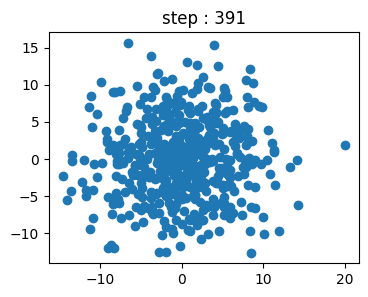

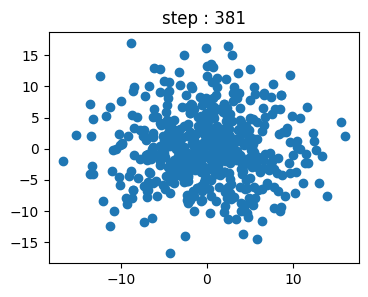

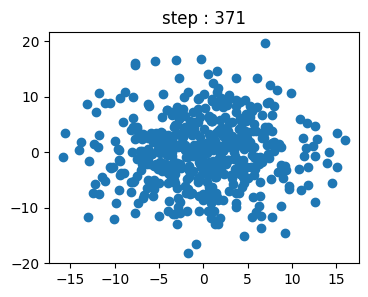

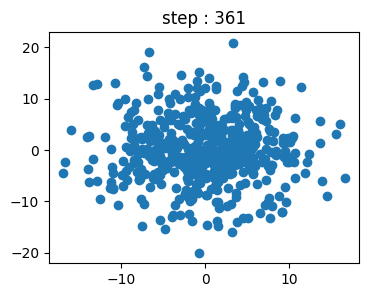

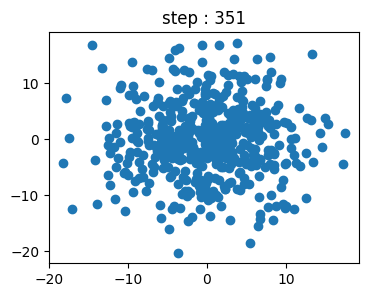

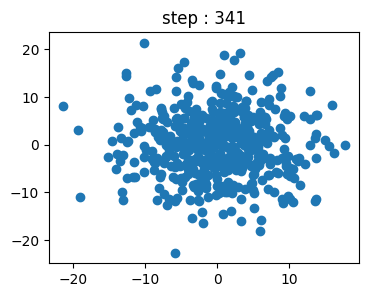

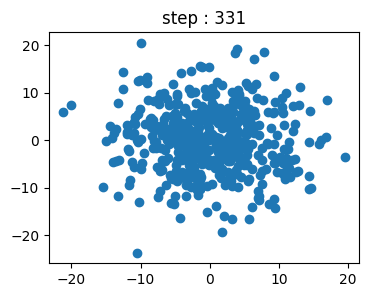

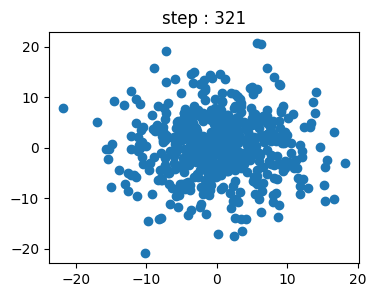

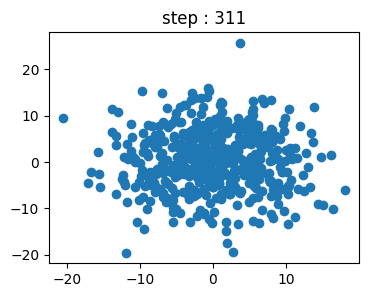

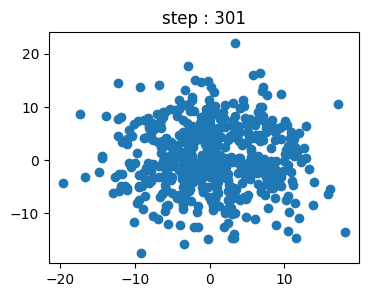

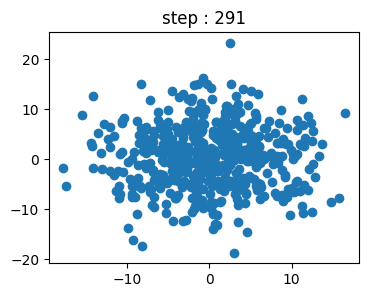

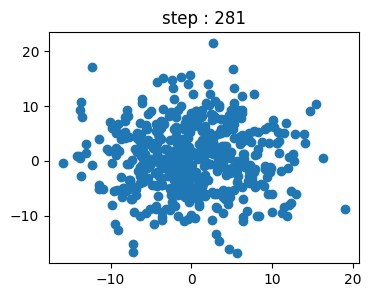

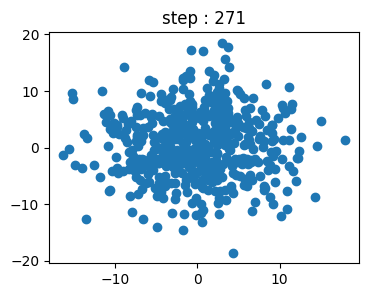

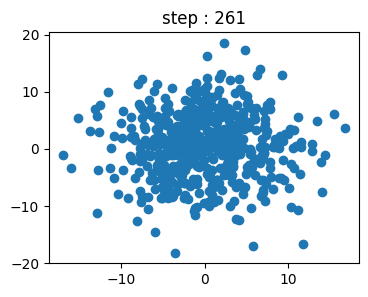

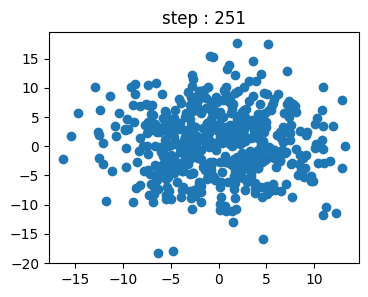

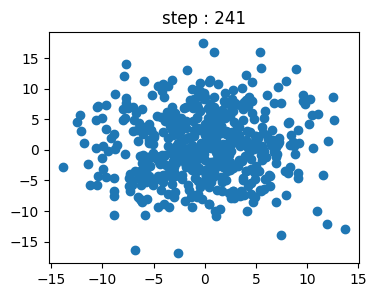

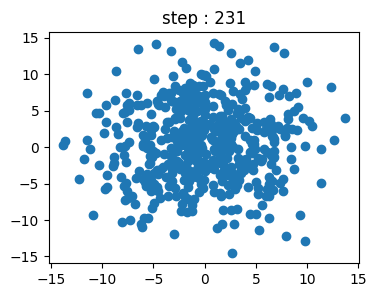

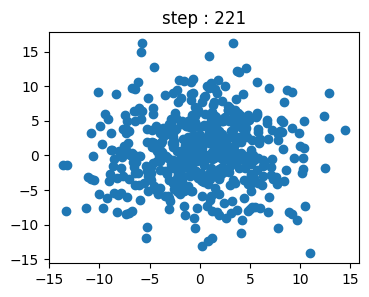

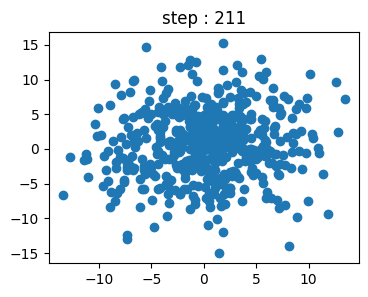

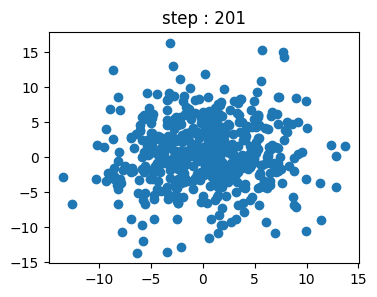

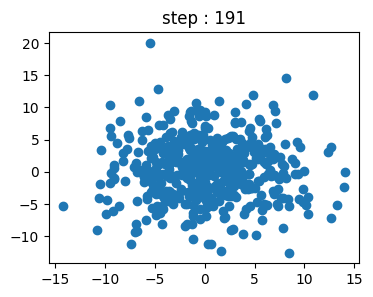

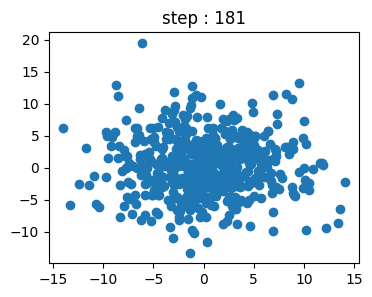

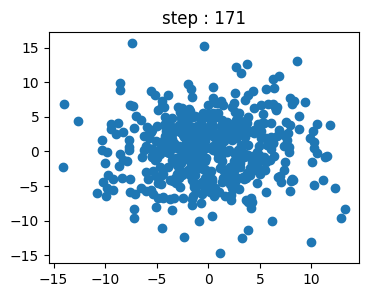

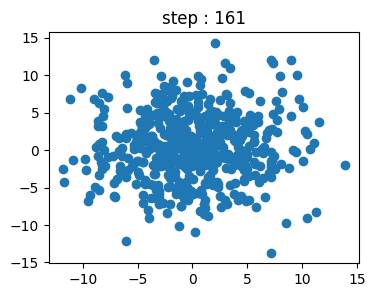

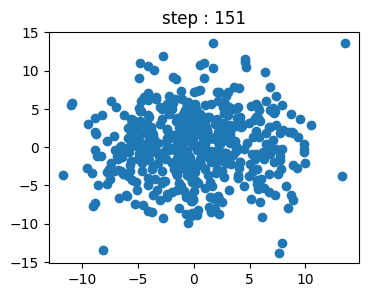

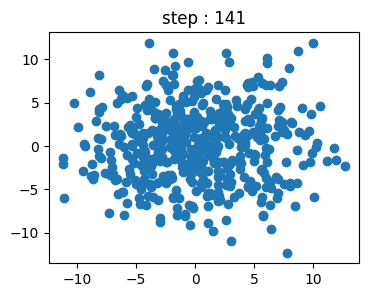

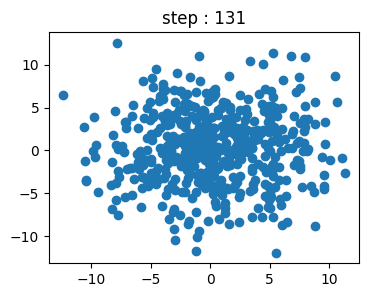

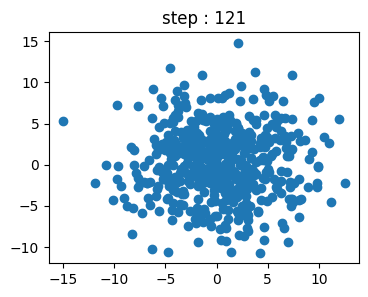

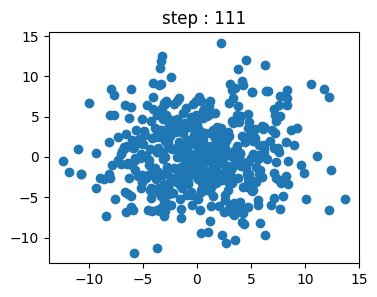

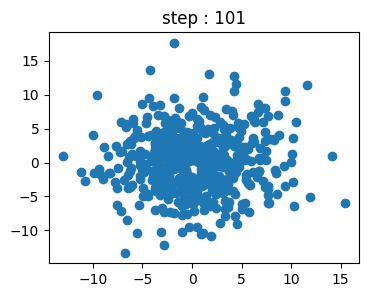

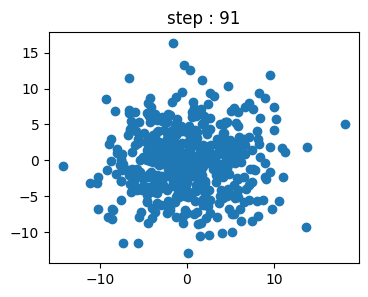

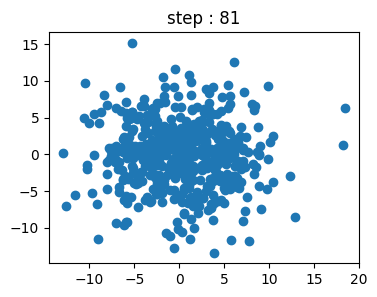

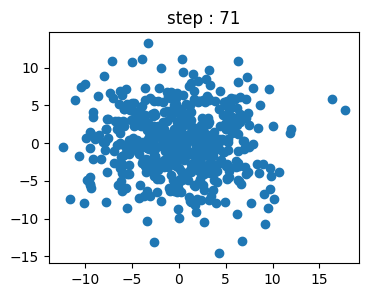

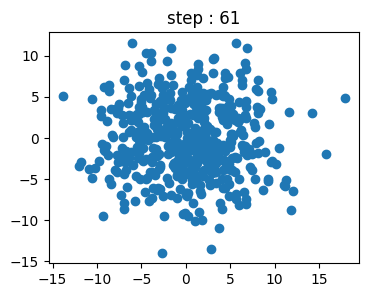

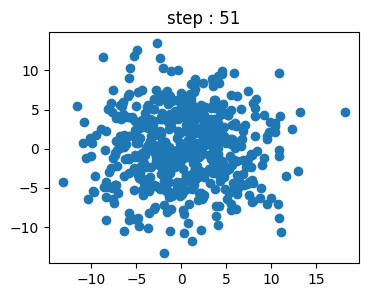

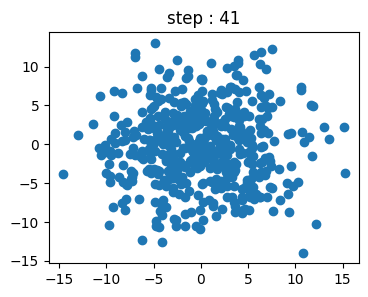

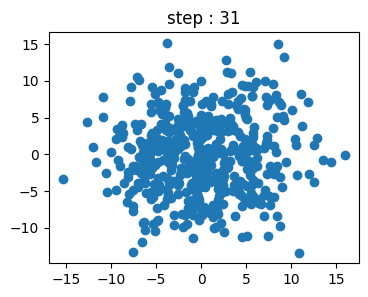

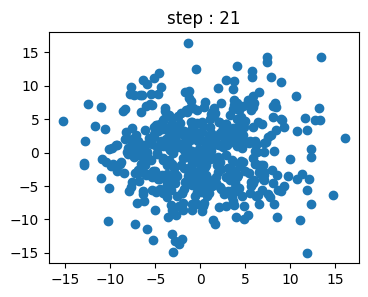

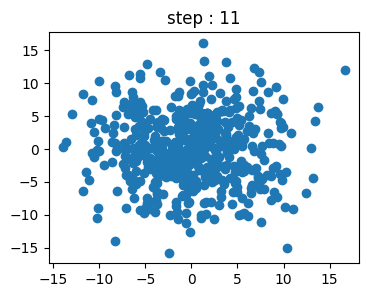

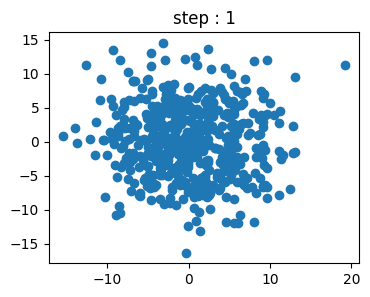

In [114]:
# test 
result = generate_batch(key, parameters)
